In [24]:
import json
import os
import shutil

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

%matplotlib inline

In [25]:
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(physical_devices[0], enable=True)

In [26]:
train_df = pd.read_csv('../data/processed/oversampled/RandomOverSampled.csv')
test_df = pd.read_csv('../data/processed/test_data_processed.csv')

In [27]:
train_df

,Unnamed: 0,description,genre
0,0,listen convers doctor parent 10-year-old oscar...,drama
1,1,brother sister past incestu relationship curre...,thriller
2,2,bu empti student field trip museum natur histo...,adult
3,3,help unemploy father make end meet edith twin ...,drama
4,4,film titl refer un-recov bodi ground zero also...,drama
...,...,...,...
350631,350631,ruthless bounti hunter track sadist outlaw gun...,western
350632,350632,high noonreal high two stagecoach deliveri boy...,western
350633,350633,mark jackson scheme get adam land gang rob ada...,western
350634,350634,gunfight surviv hang help young widow tri keep...,western


In [28]:
test_df

,id,title,genre,description,year,language,processed_description_string
0,1,Edgar's Lunch,thriller,"L.R. Brane loves his life - his car, his apar...",1998,English,lr brane love life - car apart job especi girl...
1,2,La guerra de papá,comedy,"Spain, March 1964: Quico is a very naughty ch...",1977,English,spain march 1964 : quico naughti child three b...
2,3,Off the Beaten Track,documentary,One year in the life of Albin and his family ...,2010,English,one year life albin famili shepherd north tran...
3,4,Meu Amigo Hindu,drama,"His father has died, he hasn't spoken with hi...",2015,English,father die hasnt spoken brother 10 year seriou...
4,5,Er nu zhai,drama,Before he was known internationally as a mart...,1955,English,known intern martial art superstar bruce lee a...
...,...,...,...,...,...,...,...
48765,54196,"""Tales of Light & Dark""",horror,"Covering multiple genres, Tales of Light & Da...",2013,English,cover multipl genr tale light dark antholog we...
48766,54197,Der letzte Mohikaner,western,As Alice and Cora Munro attempt to find their...,1965,English,alic cora munro attempt find father british of...
48767,54198,Oliver Twink,adult,A movie 169 years in the making. Oliver Twist...,2007,English,movi 169 year make oliv twist art dodger fagin...
48768,54199,Slipstream,drama,"Popular, but mysterious rock D.J Mike Mallard...",1973,English,popular mysteri rock dj mike mallard askew bro...


In [29]:
# # Remove thriller
# train_df = train_df[train_df['genre'] != 'thriller']
# test_df = test_df[test_df['genre'] != 'thriller']

In [30]:
unique_genres = train_df['genre'].unique()
genre_encoding = dict([(unique_genres[i], i) for i in range(unique_genres.shape[0])])
genre_encoding_inv = dict(zip(genre_encoding.values(), genre_encoding.keys()))
train_df['genre'] = train_df['genre'].map(genre_encoding)
test_df['genre'] = test_df['genre'].map(genre_encoding)

In [31]:
num_labels = train_df['genre'].nunique()
num_labels

26

In [32]:
# with open(os.path.join('../models', 'genre_encoding.json'), 'w') as f:
#     json.dump(genre_encoding_inv, f)

In [33]:
import matplotlib.pyplot as plt
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score, classification_report


def get_confusion_matrix(y_true, y_pred):
    fig, ax = plt.subplots(figsize=(15, 15))
    ConfusionMatrixDisplay.from_predictions(y_true, y_pred, ax=ax)
    plt.show()
    return None

In [34]:
x_train = train_df['description'].values
y_train = pd.get_dummies(train_df['genre']).values

In [35]:
x_test = test_df['processed_description_string'].values
y_test = pd.get_dummies(test_df['genre']).values

## Small BERT

In [36]:
import tensorflow as tf
import tensorflow_hub as hub
import tensorflow_text as text
from official.nlp import optimization

tf.get_logger().setLevel('ERROR')

In [37]:
#@title Choose a BERT model to fine-tune

bert_model_name = 'small_bert/bert_en_uncased_L-2_H-128_A-2'

map_name_to_handle = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1',
}

map_model_to_preprocess = {
    'small_bert/bert_en_uncased_L-2_H-128_A-2':
        'https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3',
}

tfhub_handle_encoder = map_name_to_handle[bert_model_name]
tfhub_handle_preprocess = map_model_to_preprocess[bert_model_name]

print(f'BERT model selected           : {tfhub_handle_encoder}')
print(f'Preprocess model auto-selected: {tfhub_handle_preprocess}')

BERT model selected           : https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Preprocess model auto-selected: https://tfhub.dev/tensorflow/bert_en_uncased_preprocess/3


In [38]:
bert_preprocess_model = hub.KerasLayer(tfhub_handle_preprocess)

In [39]:
bert_model = hub.KerasLayer(tfhub_handle_encoder)

In [40]:
def build_classifier_model():
    text_input = tf.keras.layers.Input(shape=(), dtype=tf.string, name='text')
    preprocessing_layer = hub.KerasLayer(tfhub_handle_preprocess, name='preprocessing')
    encoder_inputs = preprocessing_layer(text_input)
    encoder = hub.KerasLayer(tfhub_handle_encoder, trainable=True, name='BERT_encoder')
    outputs = encoder(encoder_inputs)
    net = outputs['pooled_output']
    net = tf.keras.layers.Dense(128)(net)
    net = tf.keras.layers.Dense(512)(net)
    net = tf.keras.layers.Dense(256)(net)
    net = tf.keras.layers.Dropout(0.2)(net)
    net = tf.keras.layers.Dense(num_labels, activation='softmax')(net)
    return tf.keras.Model(text_input, net)

In [41]:
classifier_model = build_classifier_model()

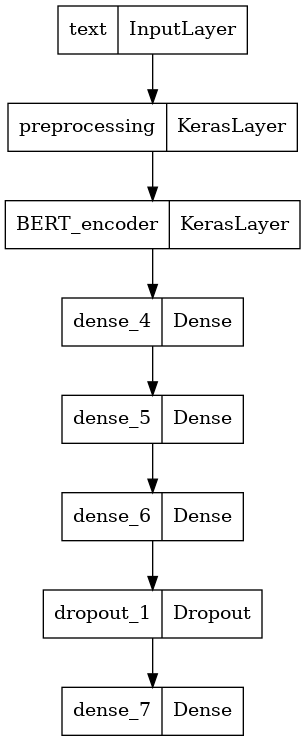

In [42]:
tf.keras.utils.plot_model(classifier_model, to_file='../models/{}.png'.format(bert_model_name))

In [43]:
epochs = 2

In [44]:
classifier_model.compile(optimizer='adam',
                         loss='categorical_crossentropy',
                         metrics=['accuracy'])

In [45]:
print(f'Training model with {tfhub_handle_encoder}')

classifier_model.fit(x_train, y_train,
                    epochs=epochs,
                    verbose=1)

Training model with https://tfhub.dev/tensorflow/small_bert/bert_en_uncased_L-2_H-128_A-2/1
Epoch 1/2
10958/10958 [==============================] - 349s 32ms/step - loss: 0.6320 - accuracy: 0.8193
Epoch 2/2
10958/10958 [==============================] - 347s 32ms/step - loss: 0.2380 - accuracy: 0.9338


In [46]:
y_pred = classifier_model.predict(x_test)
y_pred = np.argmax(y_pred, axis=1)

In [47]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for Small BERT: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
# with open(os.path.join('../metrics', 'small_bert.txt'), 'w') as f:
#     f.write(cls_report)


 Accuracy for Small BERT:  0.5001845396760304

Classification Report

               precision    recall  f1-score   support

           0       0.64      0.39      0.48     13505
           1       0.20      0.29      0.24      1585
           2       0.51      0.38      0.44       590
           3       0.70      0.73      0.72     13042
           4       0.44      0.58      0.50      7304
           5       0.15      0.05      0.08       501
           6       0.17      0.40      0.24       880
           7       0.56      0.51      0.53      2202
           8       0.51      0.44      0.47       431
           9       0.19      0.17      0.18       496
          10       0.30      0.35      0.32      1312
          11       0.09      0.14      0.11       322
          12       0.31      0.35      0.33       646
          13       0.50      0.53      0.51       730
          14       0.27      0.24      0.26       766
          15       0.17      0.52      0.25       389
         

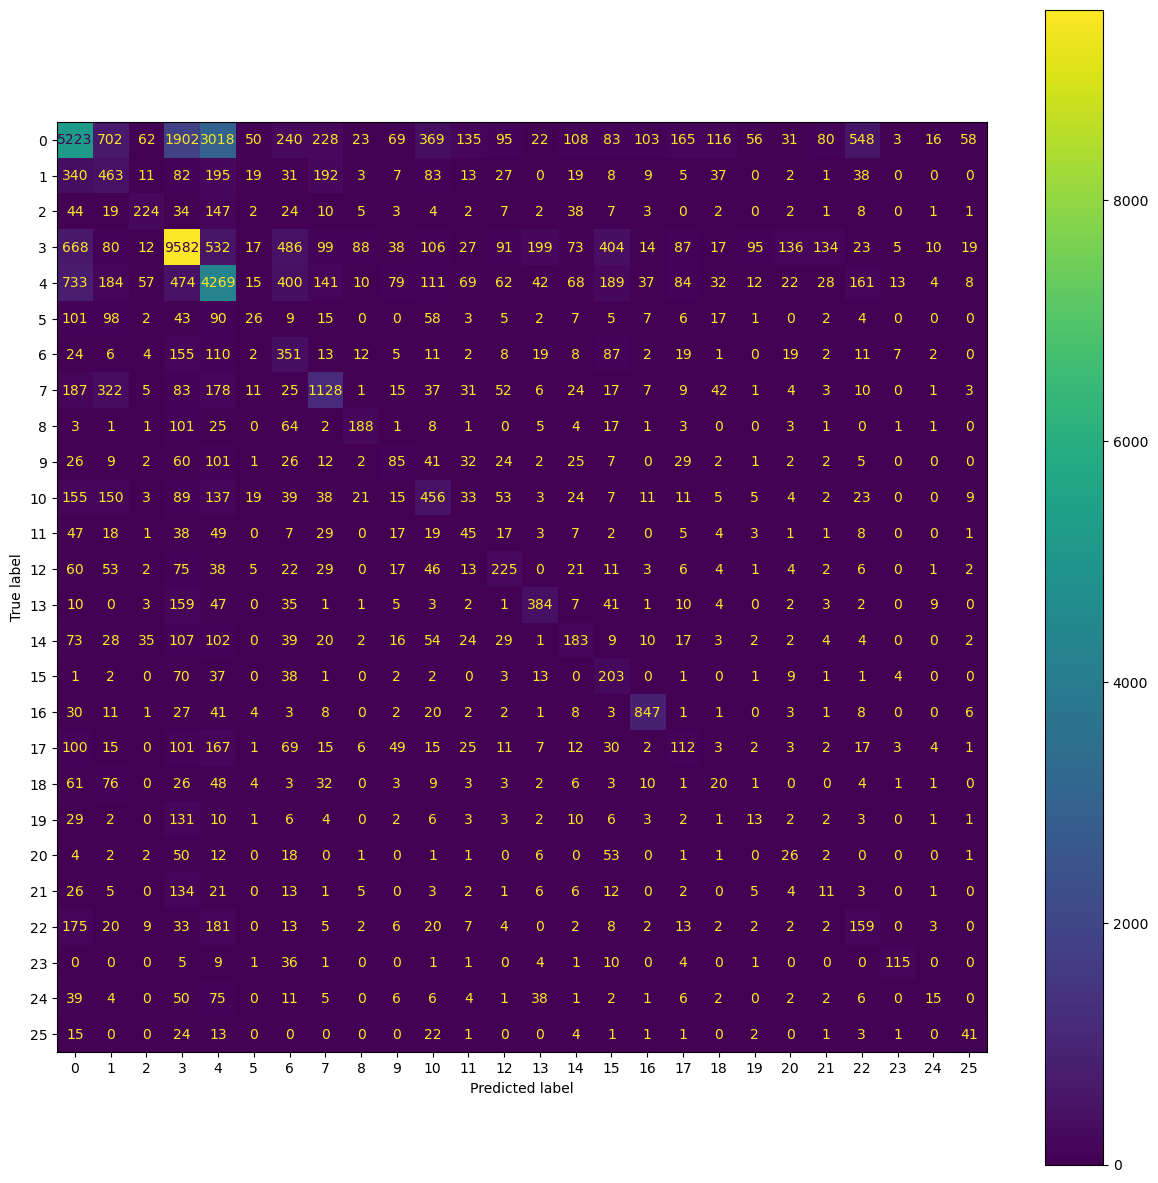

In [48]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

In [85]:
saved_model_path = '../models/{}'.format(bert_model_name)

classifier_model.save(saved_model_path, include_optimizer=False)

## TF-IDF Data Preparation

In [49]:
from sklearn.feature_extraction.text import TfidfVectorizer

In [50]:
td = TfidfVectorizer(max_features = 5000)
x_train_tf_idf = td.fit_transform(x_train)
x_test_tf_idf = td.transform(x_test)

## TF-IDF with Naive Bayes

In [60]:
from sklearn.naive_bayes import MultinomialNB

In [61]:
classifier = MultinomialNB()
classifier.fit(x_train_tf_idf, y_train.argmax(axis=1))

MultinomialNB()

In [62]:
y_pred = classifier.predict(x_test_tf_idf)

In [63]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for Naive Bayes: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
with open(os.path.join('../metrics', 'tf_idf_naive_bayes_classimbalance.txt'), 'w') as f:
    f.write(cls_report)


 Accuracy for Naive Bayes:  0.507361082632766

Classification Report

               precision    recall  f1-score   support

           0       0.71      0.47      0.56     13505
           1       0.25      0.36      0.30      1585
           2       0.41      0.58      0.48       590
           3       0.80      0.60      0.69     13042
           4       0.61      0.47      0.53      7304
           5       0.14      0.32      0.19       501
           6       0.27      0.48      0.35       880
           7       0.57      0.65      0.61      2202
           8       0.37      0.73      0.49       431
           9       0.21      0.28      0.24       496
          10       0.35      0.47      0.40      1312
          11       0.15      0.27      0.19       322
          12       0.31      0.58      0.41       646
          13       0.32      0.75      0.45       730
          14       0.22      0.23      0.22       766
          15       0.24      0.45      0.31       389
         

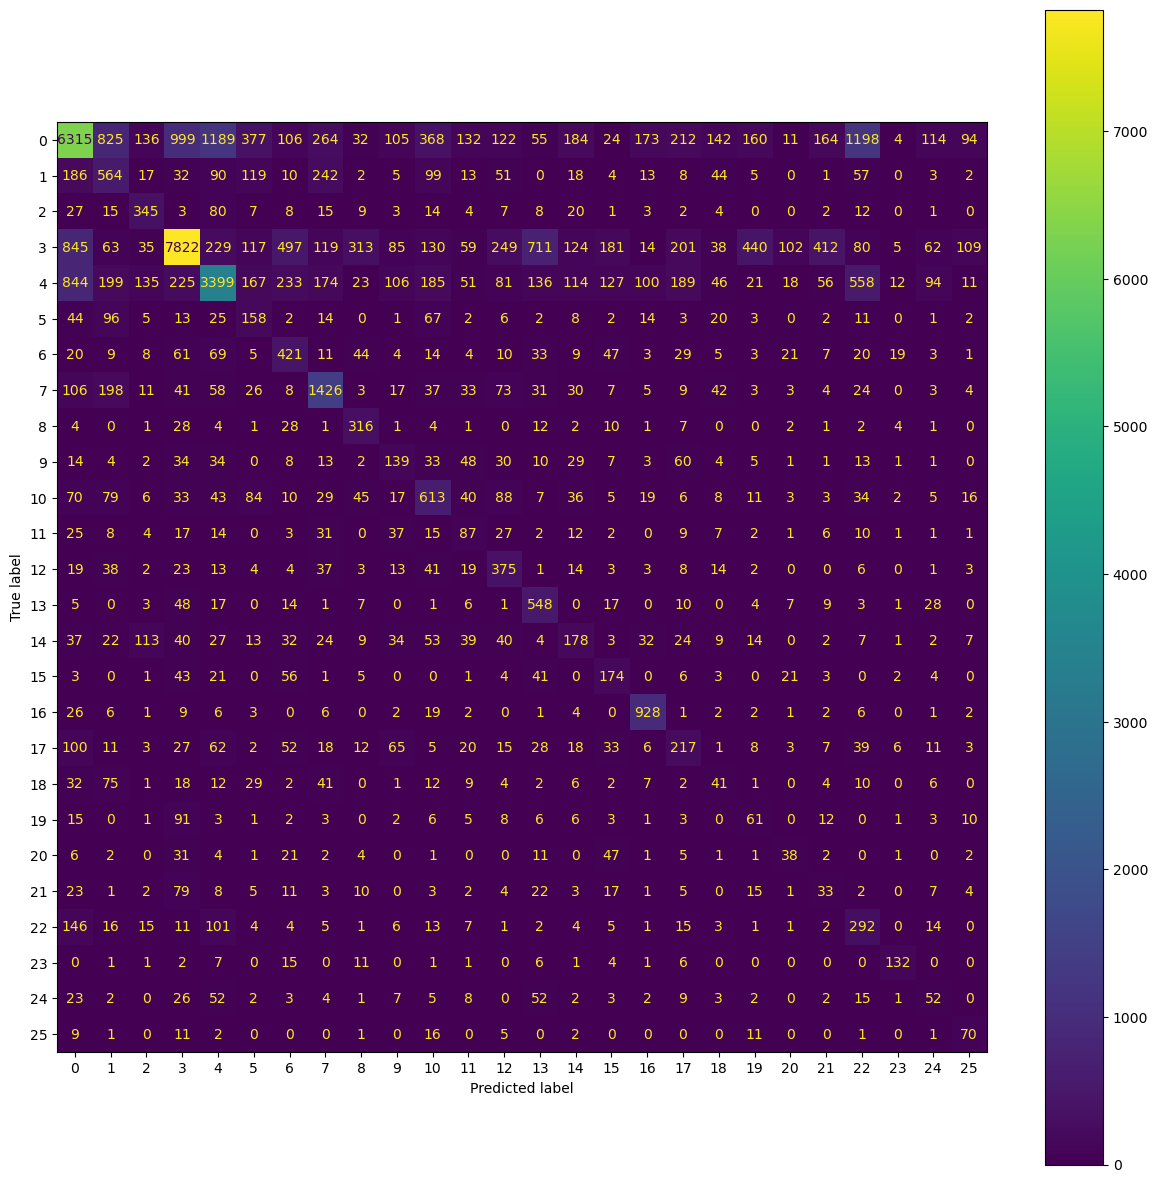

In [55]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

## TF-IDF with Random Forest

In [56]:
from sklearn.ensemble import RandomForestClassifier

In [57]:
classifier = RandomForestClassifier(verbose=3)
classifier.fit(x_train_tf_idf, y_train.argmax(axis=1))

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


building tree 1 of 100


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:   11.4s remaining:    0.0s


building tree 2 of 100


[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:   23.3s remaining:    0.0s


building tree 3 of 100
building tree 4 of 100
building tree 5 of 100
building tree 6 of 100
building tree 7 of 100
building tree 8 of 100
building tree 9 of 100
building tree 10 of 100
building tree 11 of 100
building tree 12 of 100
building tree 13 of 100
building tree 14 of 100
building tree 15 of 100
building tree 16 of 100
building tree 17 of 100
building tree 18 of 100
building tree 19 of 100
building tree 20 of 100
building tree 21 of 100
building tree 22 of 100
building tree 23 of 100
building tree 24 of 100
building tree 25 of 100
building tree 26 of 100
building tree 27 of 100
building tree 28 of 100
building tree 29 of 100
building tree 30 of 100
building tree 31 of 100
building tree 32 of 100
building tree 33 of 100
building tree 34 of 100
building tree 35 of 100
building tree 36 of 100
building tree 37 of 100
building tree 38 of 100
building tree 39 of 100
building tree 40 of 100
building tree 41 of 100
building tree 42 of 100
building tree 43 of 100
building tree 44 of 100

[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 19.5min finished


RandomForestClassifier(verbose=3)

In [58]:
y_pred = classifier.predict(x_test_tf_idf)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done   2 out of   2 | elapsed:    0.1s remaining:    0.0s
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed:    2.7s finished


In [59]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for Random Forest: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
# with open(os.path.join('../metrics', 'tf_idf_random_forest.txt'), 'w') as f:
#     f.write(cls_report)


 Accuracy for Random Forest:  0.5498462169366414

Classification Report

               precision    recall  f1-score   support

           0       0.48      0.77      0.59     13505
           1       0.37      0.10      0.15      1585
           2       0.51      0.37      0.43       590
           3       0.65      0.81      0.72     13042
           4       0.51      0.34      0.41      7304
           5       0.20      0.04      0.06       501
           6       0.51      0.10      0.17       880
           7       0.56      0.38      0.45      2202
           8       0.57      0.33      0.42       431
           9       0.34      0.06      0.10       496
          10       0.56      0.07      0.13      1312
          11       0.25      0.00      0.01       322
          12       0.40      0.27      0.32       646
          13       0.55      0.58      0.56       730
          14       0.72      0.16      0.26       766
          15       0.51      0.26      0.35       389
      

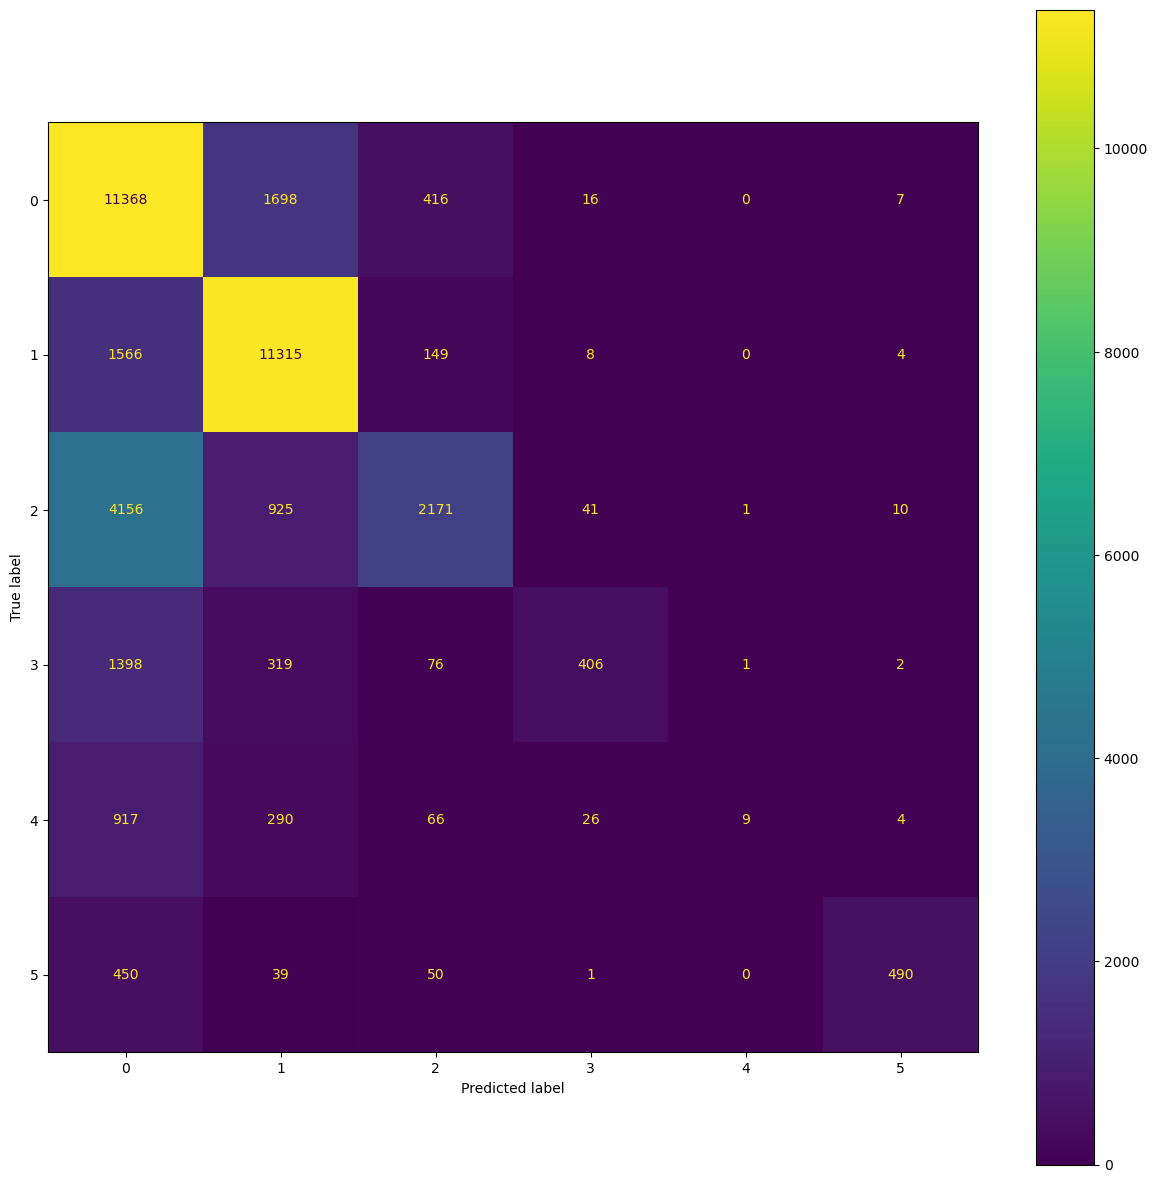

In [36]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

## Vanilla NN

In [37]:
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Embedding, GRU, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import Callback, EarlyStopping

In [38]:
num_words = 2**9
max_len = 2**5

tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\]^_`{|}~', lower=True)
tokenizer.fit_on_texts(x_train)

x_train_tokenized = tokenizer.texts_to_sequences(x_train)
x_train_tokenized = pad_sequences(x_train_tokenized, maxlen=max_len)

x_test_tokenized = tokenizer.texts_to_sequences(x_test)
x_test_tokenized = pad_sequences(x_test_tokenized, maxlen=max_len)

In [39]:
model = Sequential()
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(256))
model.add(Dropout(0.1))
model.add(Dense(128))
model.add(Dropout(0.1))
model.add(Dense(num_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [40]:
model.fit(x_train_tokenized, y_train,
                    epochs=9, batch_size=32,
                    verbose=1
                   )

Epoch 1/9
1200/1200 [==============================] - 2s 2ms/step - loss: 21.5141 - accuracy: 0.2725
Epoch 2/9
1200/1200 [==============================] - 2s 2ms/step - loss: 2.7628 - accuracy: 0.2811
Epoch 3/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.6235 - accuracy: 0.3233
Epoch 4/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.5282 - accuracy: 0.3362
Epoch 5/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.5297 - accuracy: 0.3416
Epoch 6/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.5226 - accuracy: 0.3415
Epoch 7/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.5071 - accuracy: 0.3429
Epoch 8/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.4927 - accuracy: 0.3452
Epoch 9/9
1200/1200 [==============================] - 2s 2ms/step - loss: 1.4766 - accuracy: 0.3452


In [41]:
y_pred = model.predict(x_test_tokenized)
y_pred = np.argmax(y_pred, axis=1)

In [42]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for Vanilla NN: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
with open(os.path.join('../metrics', 'vanilla_nn.txt'), 'w') as f:
    f.write(cls_report)


 Accuracy for Vanilla NN:  0.3465815861440292

Classification Report

               precision    recall  f1-score   support

           0       0.35      0.31      0.33     13505
           1       0.35      0.69      0.46     13042
           2       0.17      0.02      0.04      7304
           3       0.00      0.00      0.00      2202
           4       0.00      0.00      0.00      1312
           5       0.00      0.00      0.00      1030

    accuracy                           0.35     38395
   macro avg       0.15      0.17      0.14     38395
weighted avg       0.28      0.35      0.28     38395



/home/kah3465/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kah3465/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/kah3465/anaconda3/envs/jupyter/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1334: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start,

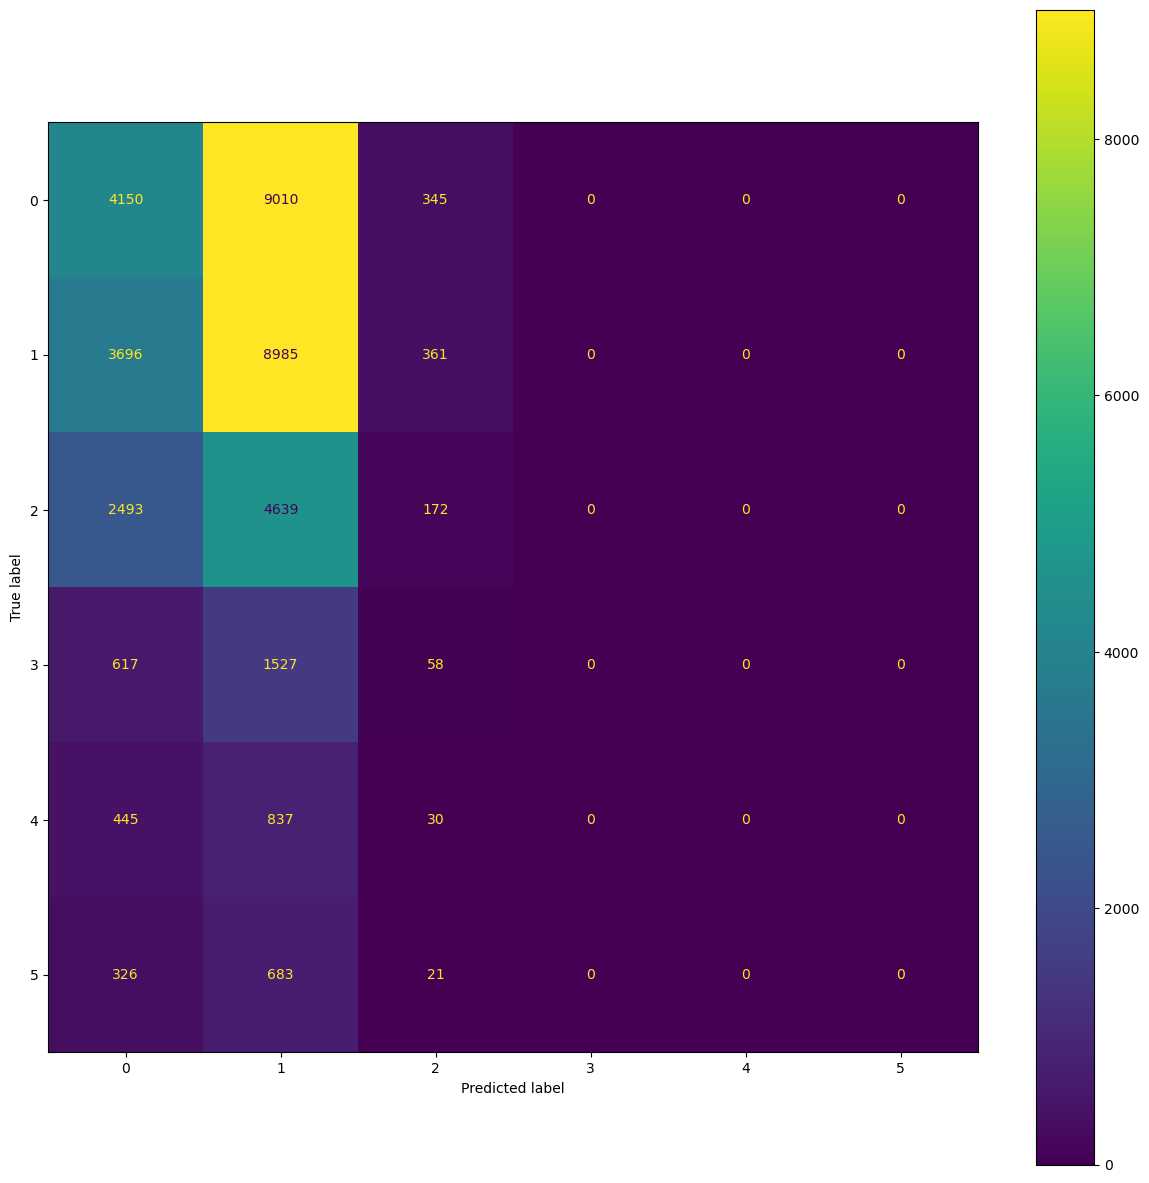

In [43]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

In [44]:
model.save('../models/nn_model')

## GRU

In [45]:
EMBEDDING_DIM = 2**5

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=x_train_tokenized.shape[1]))
model.add(GRU(256, dropout=0.1))
model.add(Dense(num_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [46]:
model.fit(x_train_tokenized, y_train,
            epochs=12, batch_size=32,
            verbose=1)

Epoch 1/12
   1/1200 [..............................] - ETA: 22:19 - loss: 1.7921 - accuracy: 0.0938

2022-11-30 14:41:50.644326: I tensorflow/stream_executor/cuda/cuda_dnn.cc:368] Loaded cuDNN version 8700


1200/1200 [==============================] - 5s 3ms/step - loss: 1.0043 - accuracy: 0.6129
Epoch 2/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.8579 - accuracy: 0.6746
Epoch 3/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.8139 - accuracy: 0.6888
Epoch 4/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7912 - accuracy: 0.6963
Epoch 5/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7770 - accuracy: 0.6999
Epoch 6/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7644 - accuracy: 0.7066
Epoch 7/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7529 - accuracy: 0.7072
Epoch 8/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7419 - accuracy: 0.7137
Epoch 9/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7304 - accuracy: 0.7199
Epoch 10/12
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7178 - accurac

In [47]:
y_pred = model.predict(x_test_tokenized)
y_pred = np.argmax(y_pred, axis=1)

In [48]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for GRU RNN: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
with open(os.path.join('../metrics', 'gru.txt'), 'w') as f:
    f.write(cls_report)


 Accuracy for GRU RNN:  0.6808438598775882

Classification Report

               precision    recall  f1-score   support

           0       0.63      0.74      0.68     13505
           1       0.81      0.83      0.82     13042
           2       0.59      0.49      0.54      7304
           3       0.65      0.36      0.46      2202
           4       0.45      0.22      0.30      1312
           5       0.64      0.58      0.61      1030

    accuracy                           0.68     38395
   macro avg       0.63      0.54      0.57     38395
weighted avg       0.68      0.68      0.67     38395



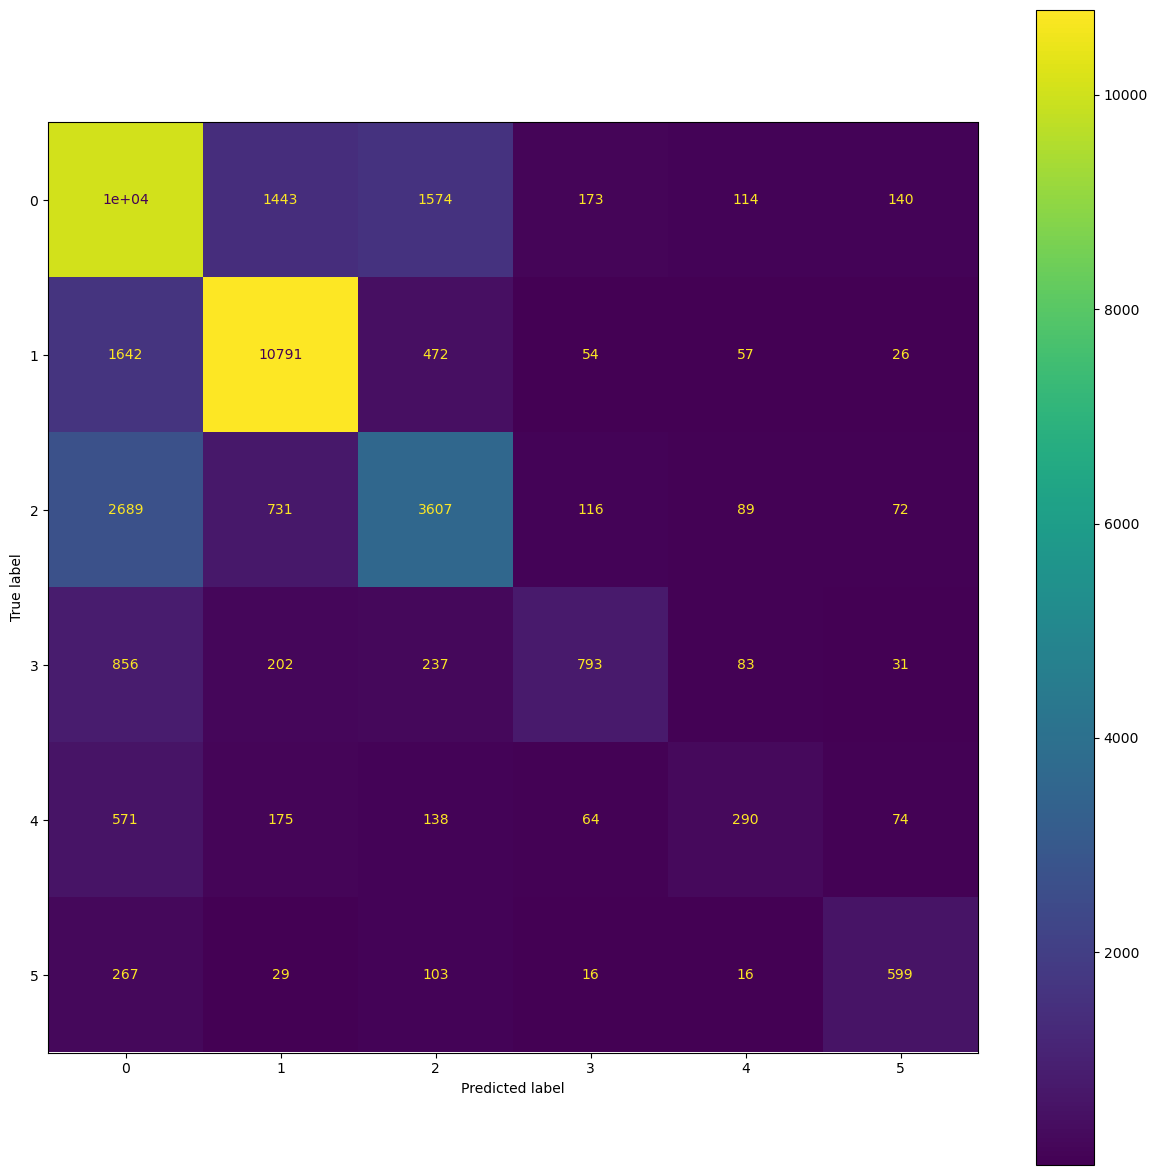

In [49]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

In [50]:
model.save('../models/gru_model')

## LSTM

In [51]:
EMBEDDING_DIM = 2**5

model = Sequential()
model.add(Embedding(num_words, EMBEDDING_DIM, input_length=x_train_tokenized.shape[1]))
model.add(LSTM(64, dropout=0.1))
model.add(Dense(num_labels, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

In [52]:
model.fit(x_train_tokenized, y_train,
            epochs=11, batch_size=32,
            verbose=1)

Epoch 1/11
1200/1200 [==============================] - 4s 3ms/step - loss: 1.0106 - accuracy: 0.6120
Epoch 2/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.8622 - accuracy: 0.6754
Epoch 3/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.8221 - accuracy: 0.6901
Epoch 4/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.8055 - accuracy: 0.6934
Epoch 5/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7908 - accuracy: 0.6984
Epoch 6/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7775 - accuracy: 0.7033
Epoch 7/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7653 - accuracy: 0.7063
Epoch 8/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7567 - accuracy: 0.7088
Epoch 9/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.7493 - accuracy: 0.7115
Epoch 10/11
1200/1200 [==============================] - 3s 3ms/step - loss: 0.741

In [53]:
y_pred = model.predict(x_test_tokenized)
y_pred = np.argmax(y_pred, axis=1)

In [54]:
cls_report = classification_report(y_test.argmax(axis=1), y_pred)
print('\n Accuracy for LSTM RNN: ', accuracy_score(y_test.argmax(axis=1), y_pred))
print('\nClassification Report')
print('======================================================')
print('\n', cls_report)
with open(os.path.join('../metrics', 'lstm.txt'), 'w') as f:
    f.write(cls_report)


 Accuracy for LSTM RNN:  0.67896861570517

Classification Report

               precision    recall  f1-score   support

           0       0.67      0.65      0.66     13505
           1       0.80      0.84      0.82     13042
           2       0.54      0.60      0.57      7304
           3       0.56      0.49      0.52      2202
           4       0.41      0.27      0.33      1312
           5       0.70      0.51      0.59      1030

    accuracy                           0.68     38395
   macro avg       0.61      0.56      0.58     38395
weighted avg       0.68      0.68      0.68     38395



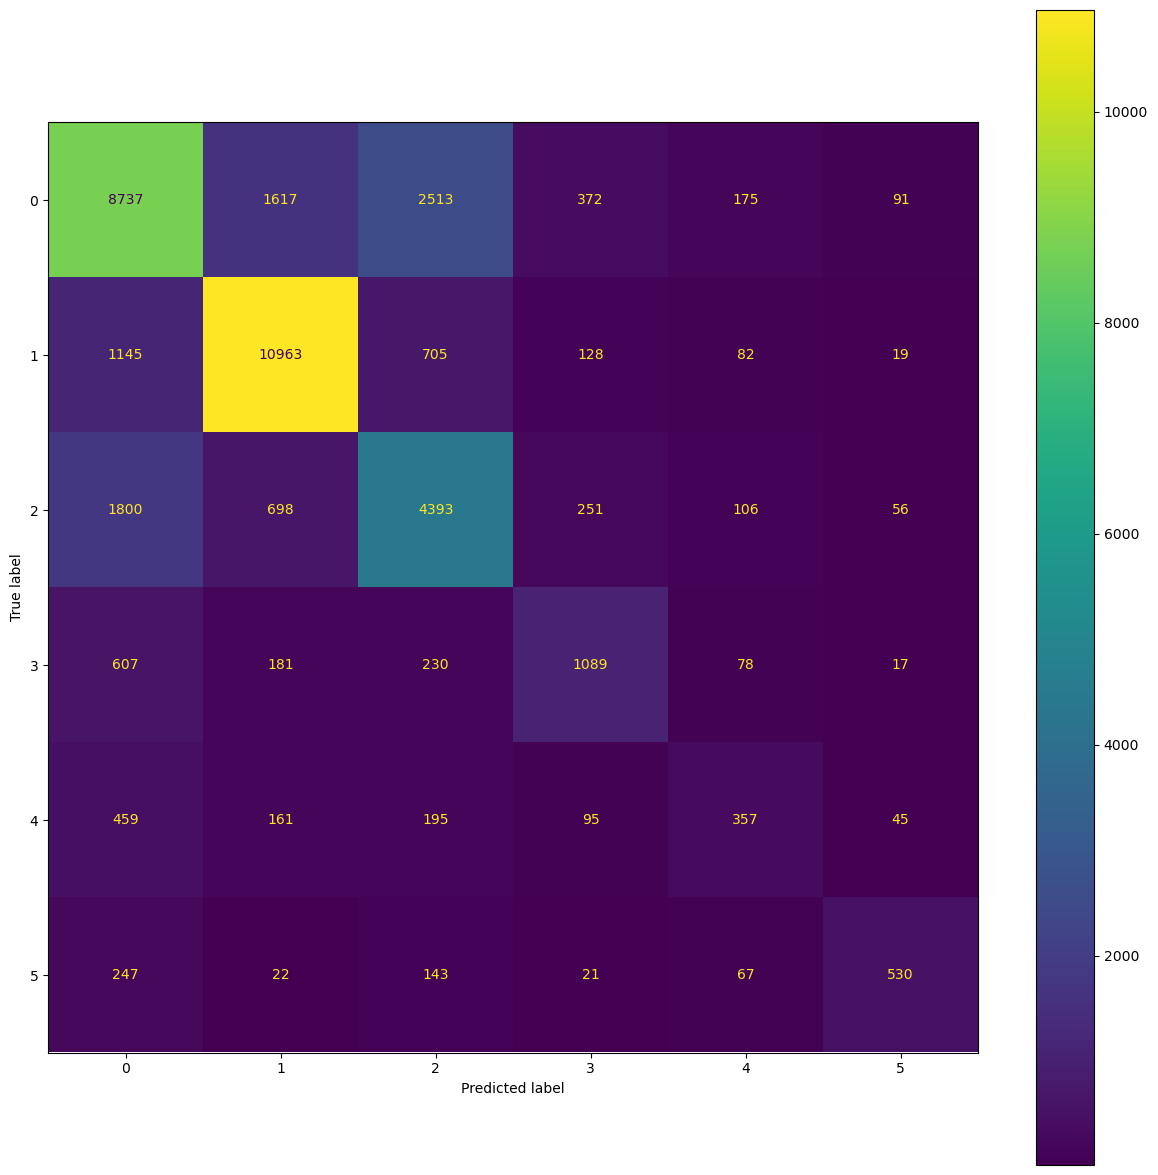

In [55]:
get_confusion_matrix(y_test.argmax(axis=1), y_pred)

In [56]:
model.save('../models/lstm_model')

In [57]:
s = "An elite group of mercenaries named The Expendables, who are based in New Orleans deploys to the Gulf of Aden to save hostages on a vessel from Somali pirates. The team consists of leader Barney Ross, blade specialist Lee Christmas, martial artist Yin Yang, military veteran Gunner Jensen, weapons specialist Hale Caesar, and demolitions expert Toll Road. Jensen instigates a firefight, causing casualties for the pirates. He then tries to hang a pirate, but Yang stops him when Ross and the team discourage the idea. Ross reluctantly discharges him from the team. Later, Christmas is upset to discover his girlfriend Lacy has left him for another man. Ross and rival Trench Mauser visit 'Mr.Church' for a mission. Trench passes the contract to Ross, which is to overthrow dictator General Garza in Vilena, an island in the Gulf of Mexico. Ross and Christmas fly to Vilena for undercover reconnaissance and meet their contact, Sandra, but are discovered. It is revealed that ex-CIA officer James Munroe is keeping Garza in power as a figurehead for his own profiteering operations, while Sandra is revealed to be Garza's daughter. Ross aborts, but Sandra refuses to leave Vilena. Meanwhile, Jensen approaches Munroe to help and Garza is angered further when Sandra is waterboarded for information by Munroe. Meanwhile, Lacy has been physically abused by her new man, so Christmas beats him and his friends, revealing what he does for a living. Ross and the group discover that Church is a CIA operative and the real target is Munroe, who has gone rogue and joined forces with Garza to keep the drug money that funds the CIA to himself, but the CIA cannot afford a mission to kill one of their own directly because of bad publicity. Ross meets tattoo expert and friend Tool to express his feelings. Tool makes a confession about letting a woman commit suicide instead of saving her. Ross is then motivated to go back for Sandra alone, but Yang accompanies him. Jensen and hired men pursue them on the road, ending in an abandoned warehouse, where Yang and Jensen fight a second time. Ross shoots Jensen when he attempts to impale Yang on a pipe. Jensen makes amends and gives the layout of Garza's palace. Ross boards the plane with Yang and finds the rest of the team waiting, and they infiltrate Garza's compound. Thinking Munroe hired the team to kill him, Garza has his soldiers' faces painted, preparing them for a fight. The team plants explosives throughout the site but Ross, while saving Sandra, is captured by Munroe's henchmen. The team saves him and kills the Brit, but is pinned down by Garza's men as Paine wrestles Ross. Caesar fights back and Paine escapes. Garza finally stands up to Munroe, ordering him out and returning his money. Instead, as Garza rallies his men against the Americans, Munroe kills him and escapes with Paine and Sandra. Garza's men open fire against the team, who fight their way through, detonating the explosives and destroying the compound. Toll kills Paine by burning him alive while Ross and Caesar manage to destroy the helicopter before Munroe can escape. Ross and Christmas catch up to Munroe, killing him and saving Sandra. Later, Ross gives his mission reward to Sandra to restore Vilena. The team has returned home and are celebrating at Tool's tattoo parlor with the recovering and now redeemed Jensen. Christmas and Tool play a game of knife throwing, during which Christmas composes a mocking poem about Tool, then throws a bullseye from outside the building."
x_custom = np.array([s.lower()])

In [58]:
genre_encoding_inv[classifier_model.predict(x_custom).argmax()]

'action'